In [2]:
# load dataset from zwhe99/DeepMath-103K

import datasets

dataset = datasets.load_dataset("zwhe99/DeepMath-103K")

print(dataset)

/home/zzhan483/miniconda3/envs/lvm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zzhan483/miniconda3/envs/lvm/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


DatasetDict({
    train: Dataset({
        features: ['question', 'final_answer', 'difficulty', 'topic', 'r1_solution_1', 'r1_solution_2', 'r1_solution_3'],
        num_rows: 103022
    })
})


In [3]:
# random sample 10000 data from dataset
sampled_dataset = dataset['train'].shuffle(seed=42).select(range(10000))

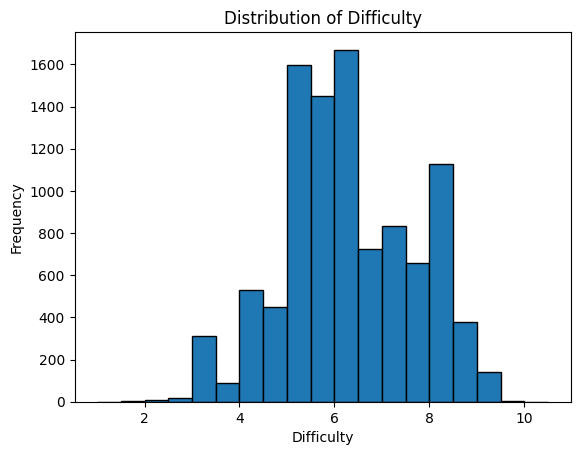

In [4]:
# distribution of difficulty
import matplotlib.pyplot as plt
difficulty_distribution = list(sampled_dataset['difficulty'])

plt.hist(difficulty_distribution, bins=[i * 0.5 for i in range(int(min(difficulty_distribution) * 2), int(max(difficulty_distribution) * 2) + 2)], edgecolor='black')
plt.title('Distribution of Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Frequency')
plt.show()

In [5]:
#　'question', 'final_answer', 'difficulty', 'topic', 'r1_solution_1', 'r1_solution_2', 'r1_solution_3'
MATH_QUERY_TEMPLATE = """
Please reason step by step, and put your final answer within \\boxed{{}}.

{Question}
""".strip()
messages = []
for i in range(len(sampled_dataset)):
    # print(sampled_dataset[i]['question'])
    # print(sampled_dataset[i]['final_answer'])
    # print(sampled_dataset[i]['difficulty'])
    # print(sampled_dataset[i]['topic'])
    message = [{"role": "user", "content": MATH_QUERY_TEMPLATE.format(Question=sampled_dataset[i]["question"])}]
    messages.append(message)

In [ ]:
import openai

client = openai.Client(base_url=f"http://127.0.0.1:10001/v1", api_key="None")

data = []
for i in range(len(sampled_dataset)):
    message = [{"role": "user", "content": MATH_QUERY_TEMPLATE.format(Question=sampled_dataset[i]["question"])}]

    response = client.chat.completions.create(
        model="Qwen/Qwen3-4B-Instruct-2507",
        messages=message,

        temperature=0.6,
        max_tokens=5000,
        top_p=0.9,
    )
    answer = response.choices[0].message.content
    single_data = {
        "conversations": [
            {
                "from": "human",
                "value": MATH_QUERY_TEMPLATE.format(Question=sampled_dataset[i]["question"])
            },
            {
                "from": "gpt",
                "value": answer
            },
        ],
        "difficulty": sampled_dataset[i]["difficulty"],
    }
    data.append(single_data)